In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

# TP: Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

<div class='alert alert-block alert-warning'>
            Answer:</div>

If we write the problem with constraints, we obtain:

$$
\left\{
\begin{array}{l}
    \displaystyle \mathop{\mathrm{argmin}}_{\mathbf{w} \in \mathcal{H}, \, w_0 \in \mathbb{R}, \, \xi \in \mathbb{R}^n} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^n \xi_i \\
    \forall i \in \{1,..,n\}, \quad \xi_i \ge 0 \\
    \forall i \in \{1,..,n\}, \quad \xi_i \ge 1 - y_i(\langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0)
\end{array}
\right.
$$


We can rewrite the two conditions thanks to the notation of the courses: $(z)_+ = max(0,z)$. We have the same optimization problem:

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

<div class='alert alert-block alert-warning'>
            Answer:</div>

We denote by h the hinge function so we can rewrite the problem as follows:

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n h(y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )) \right) $$

Hinge function is a convex function, if we do a mistake on the classification of a date we going to have $h(y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )) > 0)$. So hinge function penalizes misclassification because $C>0$. So an SVM minimzes the classification error using a convex upper bound.

Suppose that pivotal loss is Hinge loss, pivotal loss is a continuous error contrary to binary classification. It means that the pivotal loss takes in account the confident we have in the answer.

## Example of using the SVC class from scikit-learn

In [2]:
#  Data Generation

def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.95
Testing score : 0.85


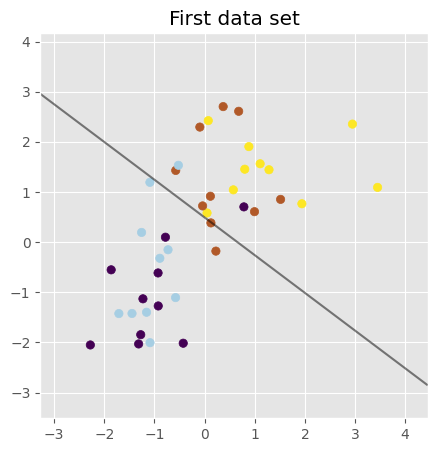

In [3]:
# This is an example of using SVC for data generated with the above function
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

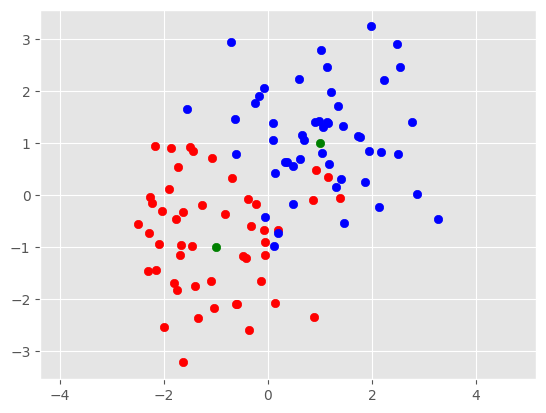

In [4]:
# Create two centers for the two distributions
centers = np.array([[1, 1], [-1, -1]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(centers=centers, random_state=0)

# Plot the points
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.scatter(centers[0,0],centers[0,1], c='g')
plt.scatter(centers[1,0],centers[1,1], c='g')
plt.axis('equal')
plt.show()

In [5]:
# Use sklearn's train_test_split to divide up data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# You need to use the imported class from scipy to generate a large number of samples which you will use
# to approximate the integral of the Bayes risk
n_mc = 10000
expectation = 0
for i in range(n_mc):
    rand = np.random.binomial(1, 0.5) # Random binary choice: will the point be generated from the first or second gaussian ?
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], np.eye(2))
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], np.eye(2))

    # You have to compute the conditional posterior probability of x given the 2 gaussians
    # Use the multivariate_normal.pdf() method !
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=np.eye(2))
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=np.eye(2))
    # Compute the risk from these and add it to the total
    expectation += min(p1,p2)

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.007
Estimated Bayes accuracy: 0.993


**5)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

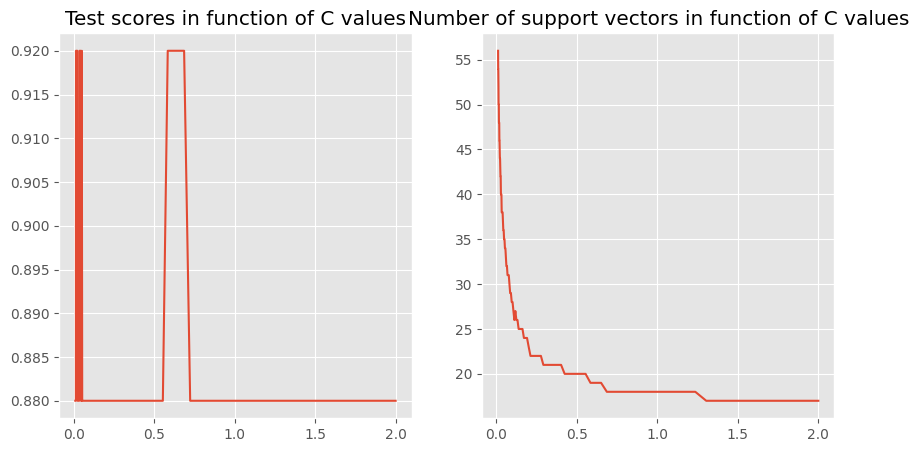

Train/Test scores: 0.92/0.92


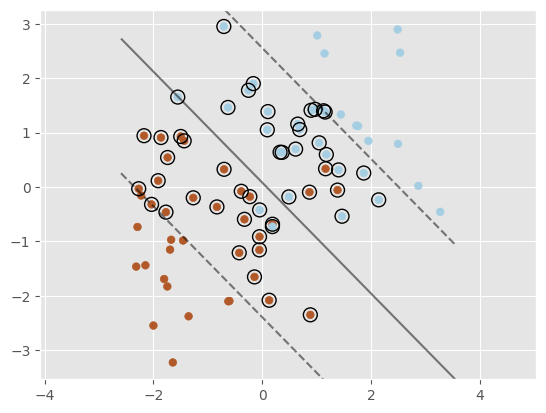

In [7]:
test_scores = []
nb_support_vectors = []
C_values = np.exp(np.linspace(np.log(0.01), np.log(2), 100))
for C in C_values:
    clf = svm.SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)
    test_scores.append(clf.score(X_test, y_test))
    nb_support_vectors.append(len(clf.support_vectors_))

# display on the same graph the test scores and the number of support vectors
plt.figure(1, figsize=(10, 5))
plt.subplot(121)
plt.plot(C_values, test_scores)
plt.title('Test scores in function of C values')
plt.subplot(122)
plt.plot(C_values, nb_support_vectors)
plt.title('Number of support vectors in function of C values')
plt.show()

C_best = C_values[np.argmax(test_scores)]

# Create a linear SVM and train it on the training data
clf = svm.SVC(kernel="linear", C=C_best)
clf.fit(X_train, y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

The number of support vectors decrease with the increase of $C$.

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

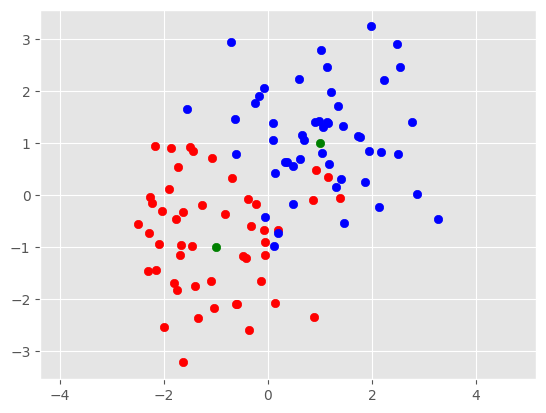

In [8]:
# Generate data and verify graphically that the two classes overlap
# Re-use the code from question 3 and 5
# Create two centers for the two distributions
centers = np.array([[1, 1], [-1, -1]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(centers=centers, random_state=0)

# Plot the points
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r')
plt.scatter(X[neg,0], X[neg,1], c='b')
plt.scatter(centers[0,0],centers[0,1], c='g')
plt.scatter(centers[1,0],centers[1,1], c='g')
plt.axis('equal')
plt.show()

Best C: 0.005672426068491977


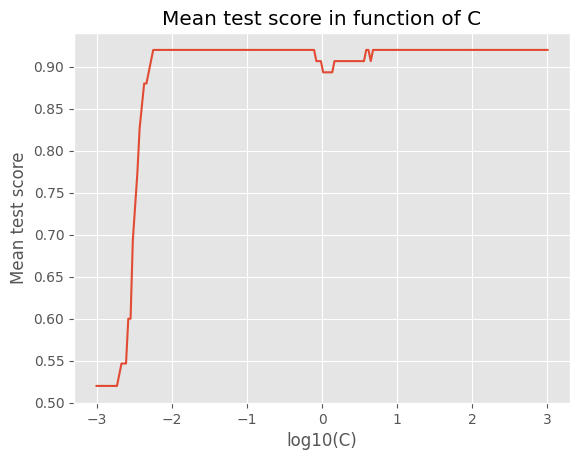

In [9]:
# Find the best working C with a 5-fold cross-validation
# Look into a bunch of values for C
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 200))}
# Use these parameters + a SVM models with GridSearchCV (look at the documentation !)

clf = GridSearchCV(SVC(), parameters, cv=5) #because 5-fold cross validation
clf.fit(X_train, y_train)
print(f'Best C: {clf.best_params_["C"]}')

#display evolution of scores
scores = clf.cv_results_['mean_test_score']
plt.plot(np.log10(parameters['C']), scores)
plt.xlabel('log10(C)')
plt.ylabel('Mean test score')
plt.title('Mean test score in function of C')
plt.show()

Train/Test scores: 0.9066666666666666/0.88


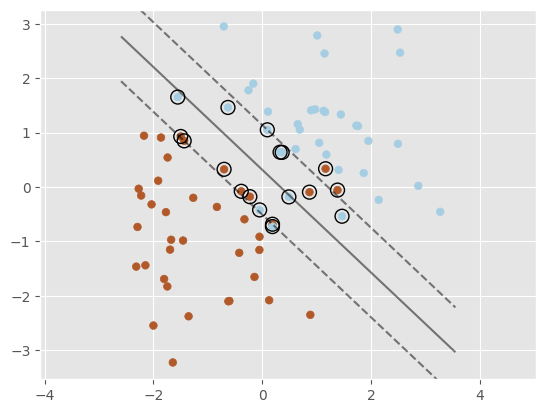

In [10]:
# Show the decision boundary with best C using question 5
C_star = clf.best_params_["C"]
clf = svm.SVC(kernel="linear", C=1)
clf.fit(X_train, y_train)
print(f'Train/Test scores: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

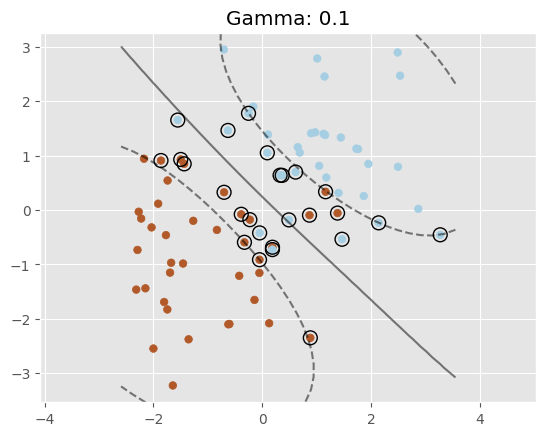

Train/Test scores: 0.92/0.88 --- Gamma: 0.1


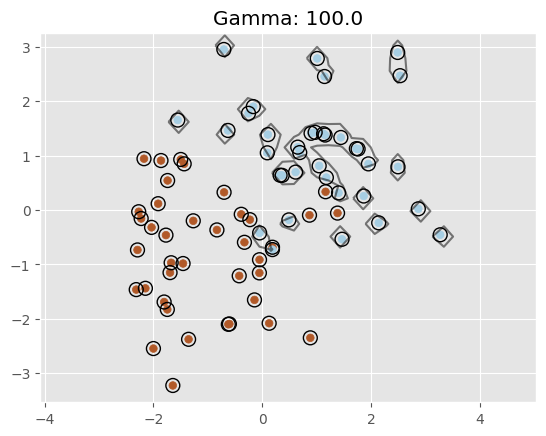

Train/Test scores: 1.0/0.52 --- Gamma: 100.0


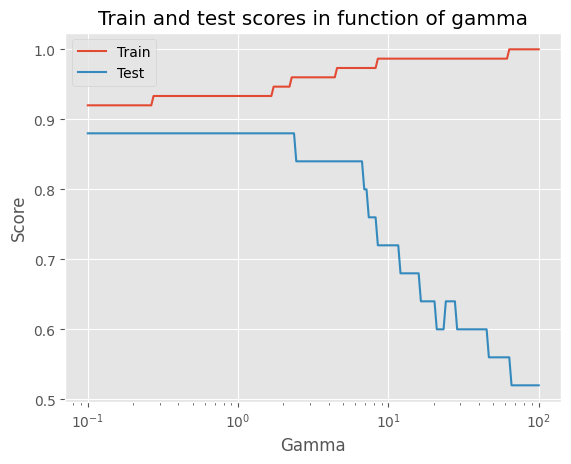

In [11]:
gammas = np.logspace(-1, 2, 200)
# Create a gaussian svm and vary the parameter of the kernel, check the difference between training and testing scores
#To create a gaussian svm we need to use rgd argument
model = svm.SVC(kernel='rbf')

scores = []

#On parcourt gammas
for gamma in gammas:
    model.gamma = gamma
    model.fit(X_train, y_train)
    #print(f'Train/Test scores: {svm.score(X_train, y_train)}/{svm.score(X_test, y_test)} --- Gamma: {gamma}')

    scores.append((model.score(X_train, y_train), model.score(X_test, y_test)))

    if gamma in [0.1, 1, 10, 100]:
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

        # plot the decision function
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = model.decision_function(xy).reshape(XX.shape)

        # plot decision boundary and margins
        ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                    linestyles=['--', '-', '--'])
        # plot support vectors
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                        linewidth=1, facecolors='none', edgecolors='k')
        

        plt.axis('equal')
        plt.title(f'Gamma: {gamma}')
        plt.show()

        print(f'Train/Test scores: {model.score(X_train, y_train)}/{model.score(X_test, y_test)} --- Gamma: {gamma}')

#display scores
plt.plot(gammas, [s[0] for s in scores], label='Train')
plt.plot(gammas, [s[1] for s in scores], label='Test')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Score')
plt.title('Train and test scores in function of gamma')
plt.legend()
plt.show()

We can see that the higher gamma is, the more the model will tend to overfit.

With $\gamma=100$, the model create areas around the training data only. Leading to a very high train score (the model overfit on training fata) but a very poor testing score.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

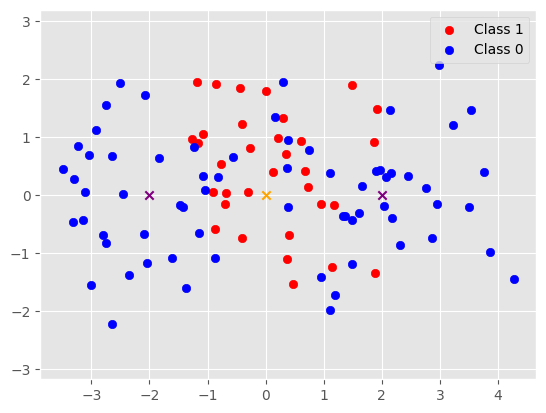

In [80]:
# Use make blobs with three centers which are aligned, for example
# Class 0 - Class 1 - Class 0

# Create three centers for the three distributions
centers = np.array([[2, 0], [0, 0], [-2, 0]])

# Use make_blobs to generate the two dimensions points from the two centers
X_nlinear, y_nlinear = make_blobs(centers=centers, n_samples=100,random_state=0)

y_nlinear[y_nlinear==2] = 0

# Plot the points
pos = np.where(y_nlinear == 1)[0]
neg = np.where(y_nlinear == 0)[0]



plt.scatter(X_nlinear[pos,0], X_nlinear[pos,1], c='r', label='Class 1')
plt.scatter(X_nlinear[neg,0], X_nlinear[neg,1], c='b', label='Class 0')
plt.scatter(centers[0,0],centers[0,1], c='purple', marker='x')
plt.scatter(centers[1,0],centers[1,1], c='orange', marker='x')
plt.scatter(centers[2,0],centers[2,1], c='purple', marker='x')
plt.axis('equal')
plt.legend()
plt.show()

**9)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

Using a linear kernel


Best C: 1e-08
Best score: 0.6699999999999999


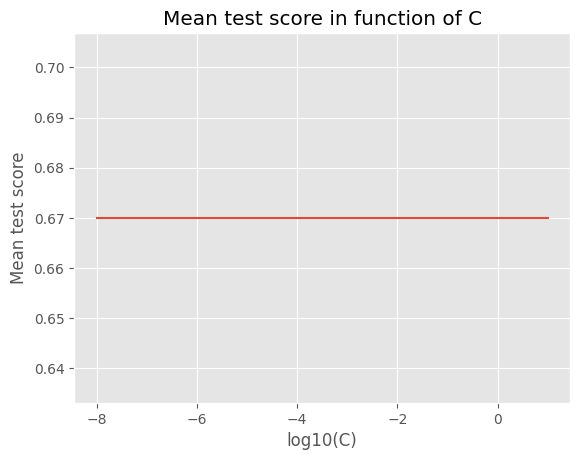

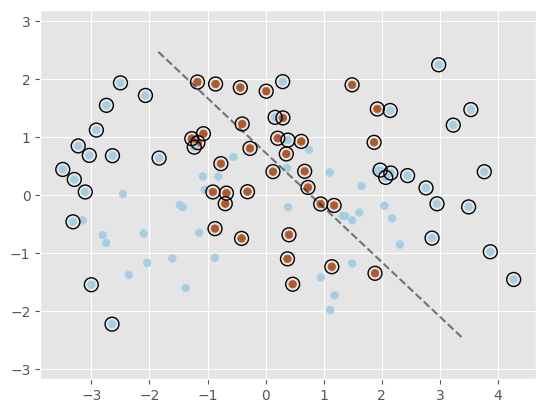

In [81]:
#linear svm
parameters = {'kernel': ['linear'], 'C': list(np.logspace(-8, 1, 10))}
clf = GridSearchCV(SVC(), parameters, cv=5) 
clf.fit(X_nlinear, y_nlinear)
print('Using a linear kernel\n\n')
print(f'Best C: {clf.best_params_["C"]}')
print(f'Best score: {clf.best_score_}')

#display evolution of scores
scores = clf.cv_results_['mean_test_score']
plt.plot(np.log10(parameters['C']), scores)
plt.xlabel('log10(C)')
plt.ylabel('Mean test score')
plt.title('Mean test score in function of C')
plt.show()

# display the decision boundary
C_star = clf.best_params_["C"]
clf = svm.SVC(kernel="linear", C=C_star)
clf.fit(X_nlinear, y_nlinear)

# Plot the data
plt.scatter(X_nlinear[:, 0], X_nlinear[:, 1], c=y_nlinear, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()


Using a gaussian kernel


Best parameters: {'C': 129.1549665014884, 'gamma': 0.05994842503189409, 'kernel': 'rbf'}
Best score: 0.8


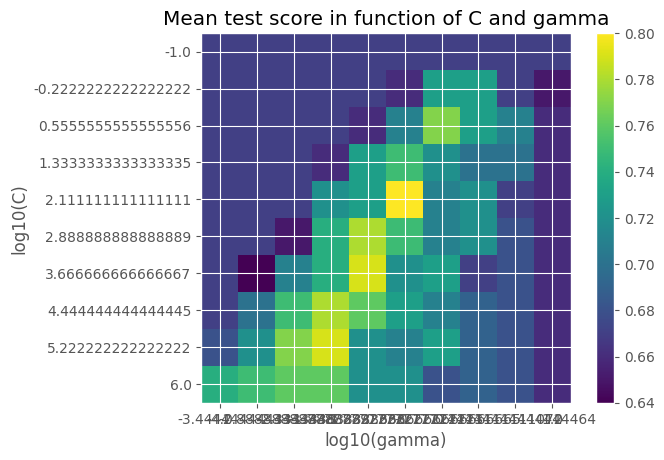

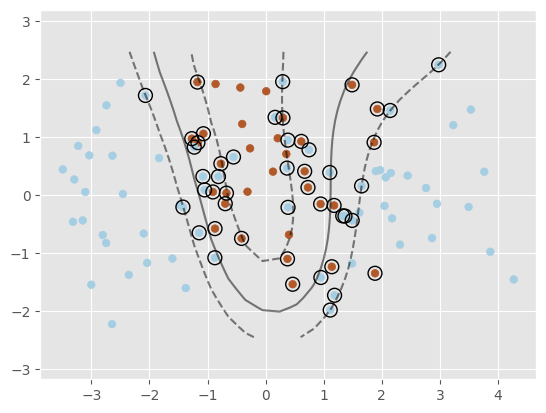

In [82]:
# Use the code of question 6 again

gammas = np.logspace(-4, 1, 10)
C_list = np.logspace(-1, 6, 10)

parameters = {'kernel': ['rbf'], 'C': C_list, 'gamma': gammas}
clf = GridSearchCV(SVC(), parameters, cv=5) 
clf.fit(X_nlinear, y_nlinear)
print('Using a gaussian kernel\n\n')
print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')

# display the map of scores
scores = clf.cv_results_['mean_test_score']
scores = scores.reshape(len(C_list), len(gammas))
plt.imshow(scores, interpolation='nearest')
plt.xlabel('log10(gamma)')
plt.ylabel('log10(C)')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), np.log10(gammas))
plt.yticks(np.arange(len(C_list)), np.log10(C_list))
plt.title('Mean test score in function of C and gamma')
plt.show()


# display the decision boundary
C_star = clf.best_params_["C"]
gamma_star = clf.best_params_["gamma"]
clf = svm.SVC(kernel="rbf", C=C_star, gamma=gamma_star)
clf.fit(X_nlinear, y_nlinear)

# Plot the data
plt.scatter(X_nlinear[:, 0], X_nlinear[:, 1], c=y_nlinear, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()


We notice that using this non-linear data repartition, linear SVM performs poorly while rbf kernel gives good overall results. 

## Learning curve

**10)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance.
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

In [102]:
# Create three centers for the three distributions
centers = np.array([[2, 0], [0, 0], [-2, 0]])

# Use make_blobs to generate the two dimensions points from the two centers
X_nlinear, y_nlinear = make_blobs(centers=centers, n_samples=500,random_state=0)

y_nlinear[y_nlinear==2] = 0

# Plot the points
pos = np.where(y_nlinear == 1)[0]
neg = np.where(y_nlinear == 0)[0]

X_train, X_test, y_train, y_test = train_test_split(X_nlinear, y_nlinear, test_size=0.25, random_state=0)

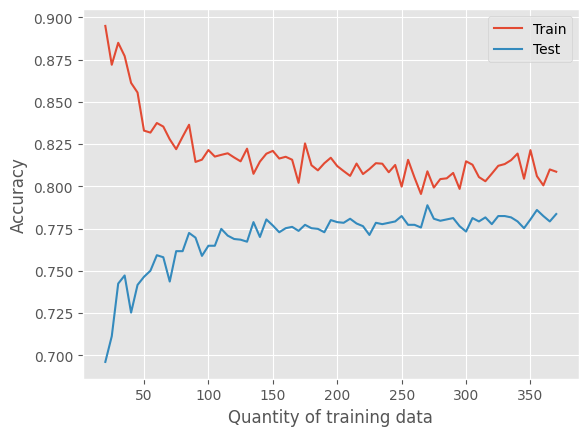

In [103]:
# Total number of training samples
n_tr = len(X_train)

# Repeat the experiment for all these training sizes
sizes = np.arange(20, n_tr, 5)

# Repeat each experiment this many times
n_m = 20

# Store scores in these lists
scores_train = []
scores_test = []

# Main loop: varying the training size
for size in sizes:
    score_train = 0
    score_test = 0
    # Second loop: repeating the experiment for each size
    for i in range(n_m):
        # Create a SVM, keeping the same parameters
        clf = svm.SVC(kernel="rbf", C=C_star, gamma=gamma_star)
        
        # For each experiment, draw a subset of the training data of the appropriate size
        idx = np.random.choice(range(n_tr), size=size)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]

        # Fit the classifier and compute the scores on training and test data
        clf.fit(X_train_reduced, y_train_reduced)
        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test += clf.score(X_test, y_test)

    # Add the average of the scores to the lists
    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)
    

# Plot the results
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [104]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)
# This is the same computation than in question 4).

n_mc = 10000
expectation = 0

for i in range(n_mc):
    #rand between 0 and 2 , equiprobable
    rand = np.random.choice([0,1,2])
    if rand == 0:
        # First case: y = 0
        x = np.random.multivariate_normal(centers[0], np.eye(2))
    elif rand == 1:
        # Second case: y = 1
        x = np.random.multivariate_normal(centers[1], np.eye(2))
    else:
        # Second case: y = 2
        x = np.random.multivariate_normal(centers[2], np.eye(2))

    # You have to compute the conditional posterior probability of x given the 2 gaussians
    # Use the multivariate_normal.pdf() method !
    p1 = multivariate_normal.pdf(x, mean=centers[0], cov=np.eye(2))
    p2 = multivariate_normal.pdf(x, mean=centers[1], cov=np.eye(2))
    p3 = multivariate_normal.pdf(x, mean=centers[2], cov=np.eye(2))
    # Compute the risk from these and add it to the total
    if p2 > p1+p3 and rand != 1:
        expectation += 1 
    elif p2 < p1+p3 and rand == 1:
        expectation += 1

expectation /= n_mc


print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')


Estimated Bayes risk: 0.211
Estimated Bayes accuracy: 0.789


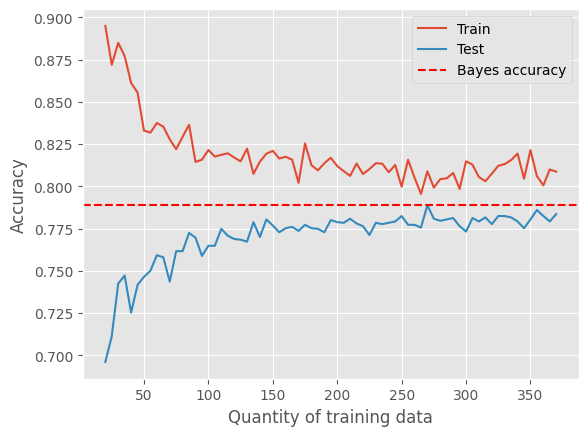

In [105]:
# Add this estimation to the plot of train/test error
# This is constant: you should add a horizontal line to your graph

plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.axhline(1 - expectation, color='r', linestyle='--', label='Bayes accuracy')
plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')

plt.legend()
plt.show()


<div class='alert alert-block alert-warning'>
            Answer:</div>

The graph shows that bayes method outperforms the model in terms of accuracy. Which is logical as the bayes estimator is the best estimator. However, we see that on training data, the bayes estimator performs underperforms our model, this is due to overfitting on training data. 

## Error versus complexity

**11)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

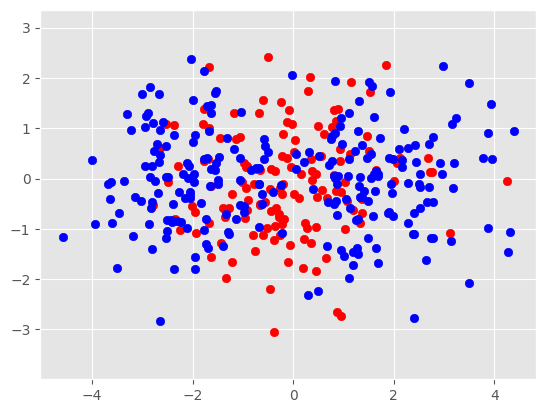

In [106]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

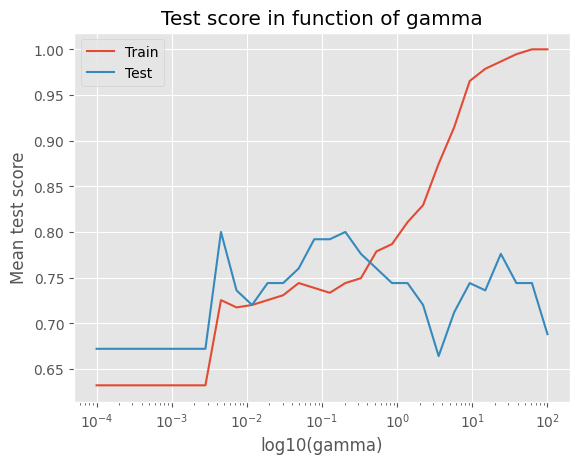

In [107]:
# Vary the appropriate parameter and plot the training/testing results

gammas = np.logspace(-4, 2, 30)
train_scores = []
test_scores = []

for gamma in gammas:
    clf = svm.SVC(kernel="rbf", C=C_star, gamma=gamma)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))


plt.plot(gammas, train_scores, label='Train')
plt.plot(gammas, test_scores, label='Test')
plt.xscale('log')
plt.xlabel('log10(gamma)')
plt.ylabel('Mean test score')
plt.title('Test score in function of gamma')
plt.legend()
plt.show()

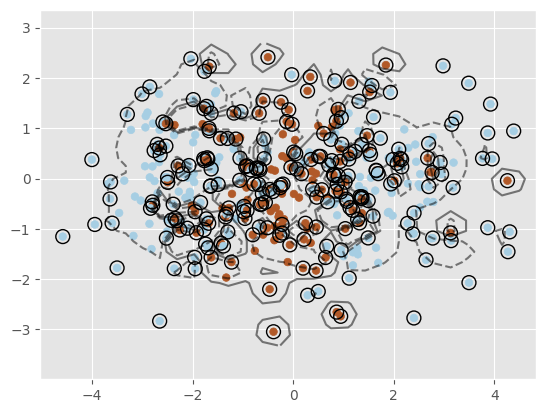

In [108]:
#display the decision boundary for gamma=10

gamma = 10
clf = svm.SVC(kernel="rbf", C=C_star, gamma=gamma)
clf.fit(X_train, y_train)

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()



<div class='alert alert-block alert-warning'>
            Answer:</div>

The first graphs shows that higher the gamma, the more the model overfits on training data. Furthermore, we can see that between $-\infty$ and $0.25$, the model performs better on testing data, this is because the model, with so few parameters, is resiliant to errors in the training dataset. And since there are no errors in the testing set, the model performs better on it. But this effect disapears as the model overfits too much on the training set. 

## Bonus : Application to face classification

Code for downloading and organizing the data:

In [120]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int_)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**12)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

<div class='alert alert-block alert-info'>
            Code:</div>

Fitting the classifier to the training set


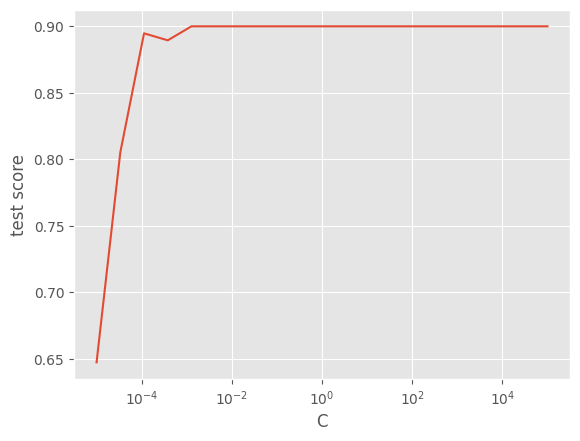

In [121]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

# Add the regularization parameter and test for a range of values
# Plot the performances
C_values = np.logspace(-5, 5, 20)
scores = []
for C in C_values:
    clf = svm.SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

plt.plot(C_values, scores)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('test score')

C_best = C_values[np.argmax(scores)]


In [122]:
print("Predicting the people names on the testing set")
t0 = time()

clf = svm.SVC(kernel="linear", C=C_best)
clf.fit(X_train, y_train)

# Predict labels for the X_test images with the best regularization parameter you obtained
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.378s
Chance level : 0.6210526315789474
Accuracy : 0.9


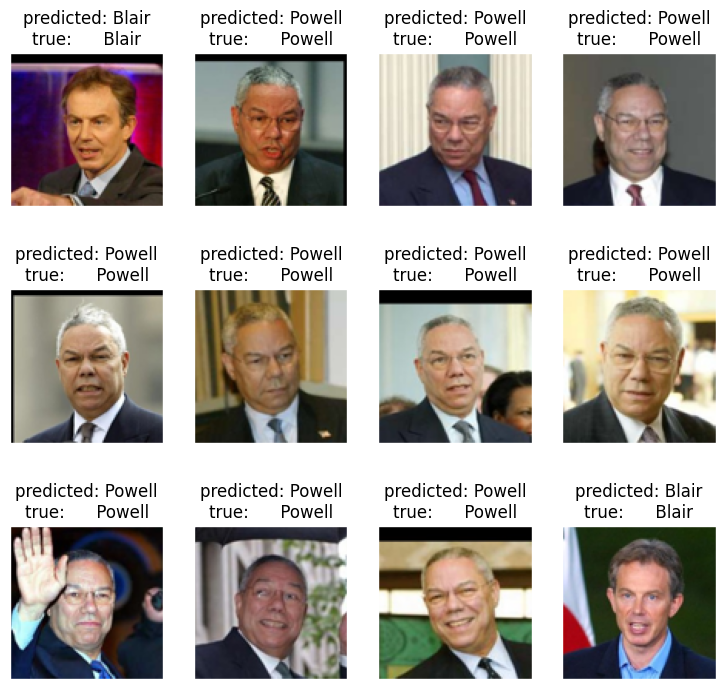

In [123]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# This will just show some examples with their associated prediction - nothing to change
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**13)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
            Code:</div>

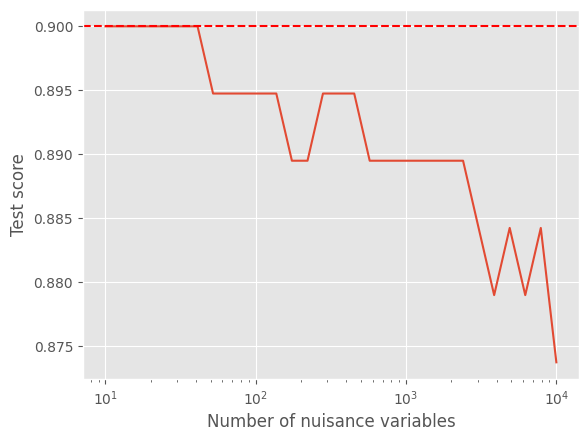

In [135]:
# Add a number of nuisance variable to the existing data points, by generating randomly their values

tab_n_nuisances = np.logspace(1, 4, 30).astype(int)
nuisance_train = np.random.randn(X_train.shape[0], np.max(tab_n_nuisances))
nuisance_test = np.random.randn(X_test.shape[0], np.max(tab_n_nuisances))

scores = []
for n_nuisance in tab_n_nuisances:
    clf = svm.SVC(kernel="linear", C=C_best)
    clf.fit(np.hstack((X_train, nuisance_train[:, :int(n_nuisance)])), y_train)
    scores.append(clf.score(np.hstack((X_test, nuisance_test[:, :int(n_nuisance)])), y_test))

# bar for without nuisance
clf = svm.SVC(kernel="linear", C=C_best)
clf.fit(X_train, y_train)
score_wo_nuisance = clf.score(X_test, y_test)

plt.plot(tab_n_nuisances, scores)
plt.axhline(score_wo_nuisance, color='r', linestyle='--', label='Without nuisance')
plt.xscale('log')
plt.xlabel('Number of nuisance variables')
plt.ylabel('Test score')
plt.show()


**14)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

Train/Test scores with pca: 1.0/0.9052631578947369
Train/Test scores without pca: 1.0/0.9
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters: {'C': 1000.0, 'gamma': 1.389495494373136e-07, 'kernel': 'rbf'}
Best score: 0.9105489417989417


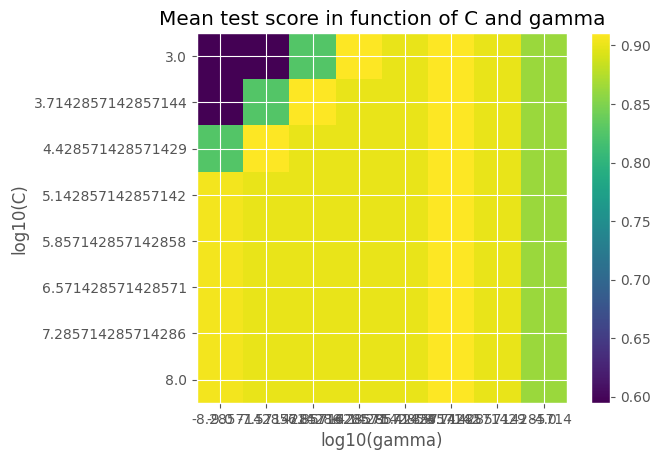

In [146]:
# Apply the SVM with the chosen kernel after dimension reduction by PCA

from sklearn.decomposition import PCA

# Create a PCA object and fit it to the training data
pca = PCA(n_components=150)
pca.fit(X_train)

# Transform the training and testing data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the SVM with the best C value
clf = svm.SVC(kernel="linear", C=C_best)
clf.fit(X_train_pca, y_train)
print(f'Train/Test scores with pca: {clf.score(X_train_pca, y_train)}/{clf.score(X_test_pca, y_test)}')

#without pca
clf = svm.SVC(kernel="linear", C=C_best)
clf.fit(X_train, y_train)
print(f'Train/Test scores without pca: {clf.score(X_train, y_train)}/{clf.score(X_test, y_test)}')



# Using a non linear kernel

# Find the best C and gamma values for the rbf kernel
gammas = np.logspace(-9, -4, 8)
C_values = np.logspace(3, 8, 8)

parameters = {'kernel': ['rbf'], 'C': C_values, 'gamma': gammas}
clf = GridSearchCV(SVC(), parameters, cv=3, verbose=1)
clf.fit(X_train, y_train)
print(f'Best parameters: {clf.best_params_}')
print(f'Best score: {clf.best_score_}')

#display heatmap
scores = clf.cv_results_['mean_test_score']
scores = scores.reshape(len(C_values), len(gammas))
plt.imshow(scores, interpolation='nearest')
plt.xlabel('log10(gamma)')
plt.ylabel('log10(C)')
plt.colorbar()
plt.xticks(np.arange(len(gammas)), np.log10(gammas))
plt.yticks(np.arange(len(C_values)), np.log10(C_values))
plt.title('Mean test score in function of C and gamma')
plt.show()



So we see that the dimension reduction helps the model to perform better on the training set. 

With a non-linear kernel, the model can perform very well, however the hyperparameters' choice is very important.